# ResNet50으로 Imagewoof 분류해보기<br>
by uramoon@kw.ac.kr

이미 훈련된 ResNet50을 불러와서 견종을 분류합니다.

이 저작물은 <a href="https://creativecommons.org/licenses/by-nc-sa/2.0/kr/">CC BY-NC-SA 2.0 KR</a>에 따라 이용할 수 있습니다. (단, 라이선스가 명시된 일부 문서 및 삽화 제외)<br>
기여하신 문서의 저작권은 각 기여자에게 있으며, 각 기여자는 기여하신 부분의 저작권을 갖습니다.<br>
Imagewoof 출처 : https://github.com/fastai/imagenette


## Imagewoof 중 일부만 압축 풀기<br>
KW_Imagewoof를 다운받아 Colab에 복사한 후 진행하세요.

In [ ]:
!unzip -q KW_imagewoof2-320.zip

## 클래스 인덱스와 이름 알아보기<br>
KW_imagewoof2-320/n0.. 폴더에는 각 클래스에 해당하는 사진이 있습니다.<br>
(왼쪽 파일 목록을 새로고침하고 KW_imagewoof2-320 폴더를 확인해보세요.)<br><br>
ImageNet은 1,000 개의 클래스를 갖고 있는데 n0..이 
1. ImageNet에서 몇 번째 클래스에 해당하는지 
2. 사람이 식별하기 위한 이름은 어떻게 되는지 살펴봅시다.<br>
(imagenet_class_index.json 파일 활용)<br>
출처: https://github.com/raghakot/keras-vis/blob/master/resources/imagenet_class_index.json



## 수업 정리
* Dense ( = Fully-Connected ) : 밀집해 있다. 완벽하게 연결되어 있다.
* Residual Neural Network
    * 특징 : Skip Connections, Shortcuts
    * image 인식, 시계열 데이터에서 자주 사용 (기온, 주가, 물체의 위치)
* 웬만한 모델에서는 MLP ( ~ Fully-Connected )가 마지막에 위치  
  그 전까지는 특징들을 추출한다.
* ImageNet - 대회 : ILSVRC ( 2012-AlexNet, 2015-ResNet )
* Top-1 Accuracy : 출력한 값들 중에 가장 높은 확률과 정답값을 비교했을 때, 정확도
* Top-5 Accuracy : 출력한 값들 중에 가장 높은 확률 5개 안에 정답값이 들어있을 때, 정확도



In [ ]:
# 0번째 클래스는 n01440764인 잉어, 1번째 클래스는 n01443537인 금붕어, ...
!head imagenet_class_index.json

{"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777", 

In [ ]:
import json
idx2label = []  # 인덱스를 입력하면 사람이 이해할 수 있는 이름표가 나옵니다.
cls2label = {}  # 'n02086240' 같은 것을 입력하면 사람이 이해할 수 있는 이름표가 나옵니다.
cls2idx = {}    # 'n02086240' 같은 것을 입력하면 인덱스가 나옵니다. [0, 999]: 인공신경망의 몇 번째 출력에 해당하는가

# ImageNet에 있는 class가 저장되어 있다.
with open("imagenet_class_index.json", "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

## TODO1: 딕셔너리 활용하기<br>
아래의 두 개를 출력해보세요.

1. n02086240은 몇 번째 클래스인가? 인덱스를 출력하세요. (모델의 출력에서 사용)
2. n02086240의 클래스 이름은 무엇인가? (인간이 식별하기 편한 이름)

In [ ]:
target = 'n02086240'
# TODO: 1번과 2번의 답을 출력해보세요.

print(cls2idx[target])
print(cls2label[target])

155
Shih-Tzu


## TODO2: 각 디렉토리에서 무작위로 5개씩 그려봅시다.<br>
총 10종의 개 이미지가 있으니 50장이 그려집니다.<br>
TODO 표시된 두 줄만 작성하시면 됩니다.

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# KW_imagewoof2-320 하위 폴더 가져오기
subfolders = [f.path for f in os.scandir('KW_imagewoof2-320') if f.is_dir()]

idx = 1
plt.figure(figsize=(25, 25))
# 각 디렉토리에서
for dir in subfolders:  
  # JPEG 파일을 5개씩 무작위로 그리기
  for i in range(5):    
    plt.subplot(10, 5, idx)
    idx = idx + 1

    rand_file = random.choice(os.listdir(dir)) # TODO: 무작위 파일 선택, Hint: Data augmentation 노트북 참조 

    img = mpimg.imread(dir + '/' + rand_file)

    # 각 그림의 제목에 클래스 이름과 그림 사이즈를 출력하세요. (예: golden_triever (높이, 너비, 채널))
    # Hint: 딕셔너리와 img.shape 활용
    # Color 이미지 이기 때문에 3차원으로 저장된다.
    plt.title(f"{cls2label[dir.split('/')[1]]} {img.shape}") # TODO: 괄호에 문자열을 넣으면 제목으로 들어감

    plt.imshow(img) 
plt.subplots_adjust(hspace=0.5) 
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## TODO3: JPEG을 224 x 224 크기의 PIL (Python Imaging Library) 이미지로 변환<br>
우리가 사용할 ResNet50은 224 x 224를 입력으로 받습니다.
1. JPEG 그려보기

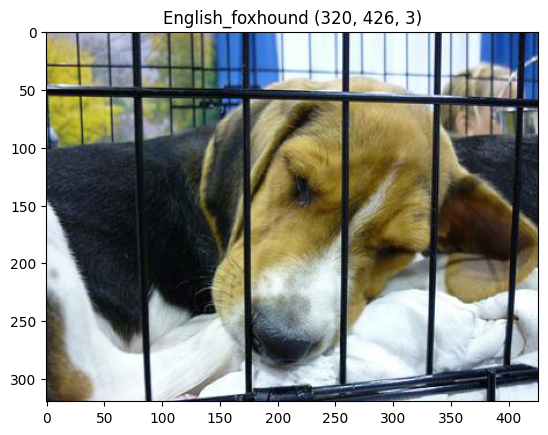

In [ ]:
# 다음 임의의 JPEG 이미지를 그려보세요.
fname = 'KW_imagewoof2-320/n02089973/ILSVRC2012_val_00003671.JPEG'


img = mpimg.imread(fname)
plt.title(f"{cls2label[fname.split('/')[-2]]} {img.shape}")
plt.imshow(img)

2. JPEG을 224 x 224 크기의 PIL image로 변환하기<br>
Hint: https://keras.io/api/preprocessing/image/ 에서 load_img 함수 사용

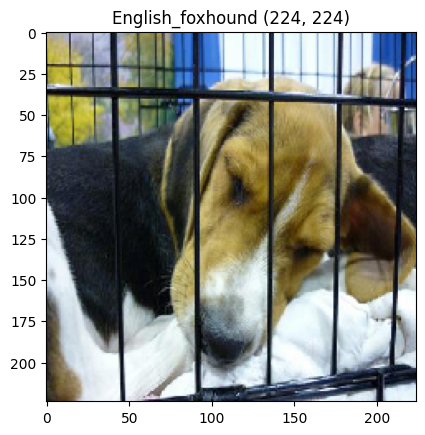

In [ ]:
from tensorflow.keras.preprocessing import image

# TODO: 상기 JPEG 파일 변환해보기
img_data = image.load_img(fname, color_mode="rgb", target_size=(224, 224), interpolation="nearest")

plt.title(f"{cls2label[fname.split('/')[-2]]} {img_data.size}") # PIL에서 shape 확인은 "size"
# img_data 그려보기 (224 x 224로 변환됐는지 확인)
plt.imshow(img_data)  # TODO: 쉽습니다. 괄호안에 이미지 객체를 넣으세요.

## TODO4: PIL 이미지를 NumPy로 변환하기<br>
Hint: https://keras.io/api/preprocessing/image/ 에서 img_to_array 함수 사용 <br>
컬러 이미지의 채널이 몇 개인지 shape를 확인해보세요. 

In [ ]:
# NumPy array로 변환 후 shape 확인하기
array = image.img_to_array(img_data)
print(array.shape)

print( type(img_data), type(array) )

(224, 224, 3)
<class 'PIL.Image.Image'> <class 'numpy.ndarray'>


## TODO5: NumPy array 각 채널 그려보기<br>
채널에 따라 적절한 컬러맵을 선택하세요.<br>
https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html

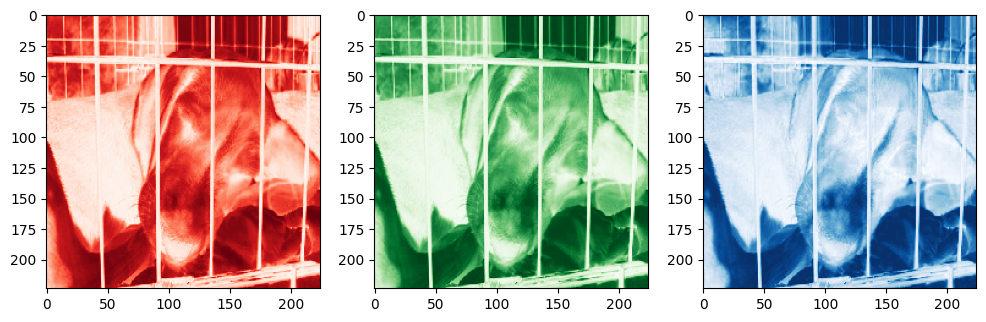

In [ ]:
r_img = array[:, :, 0] # TODO: 첫 번째 채널
g_img = array[:, :, 1] # TODO: 두 번째 채널
b_img = array[:, :, 2] # TODO: 세 번째 채널

f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.sca(axarr[0])
plt.imshow(r_img, cmap='Reds')  # TODO: 첫 번째 채널
plt.sca(axarr[1])
plt.imshow(g_img, cmap='Greens')  # TODO: 두 번째 채널
plt.sca(axarr[2])
plt.imshow(b_img, cmap='Blues')  # TODO: 세 번째 채널

## TODO6: 테스트 데이터 만들기<br>
이미 훈련이 완료된 ResNet50을 사용하기 때문에 모든 그림을 테스트 데이터로 만들어 성능을 평가해볼 것입니다.<br>
KW_imagewoof2-320 폴더 아래에 있는 모든 이미지에 대해 이미지에 해당하는 NumPy 배열과 인덱스로 구성된 레이블을 만들어야 합니다.<br>
뼈대 코드를 무시하고 자유롭게 만드셔도 됩니다.




In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

X_test = []
y_test = []

# KW_imagewoof2-320 하위 폴더 가져오기
subfolders = [f.path for f in os.scandir('KW_imagewoof2-320') if f.is_dir()]# TODO: 위에서 수행한 적 있습니다.

# 각 디렉토리에서
for dir in subfolders:  
  for fname in os.listdir(dir):
    # TODO: load_img를 이용해 224 x 224 PIL 이미지로 읽어오세요.
    img = image.load_img(os.path.join(dir, fname), color_mode="rgb", target_size=(224, 224), interpolation="nearest")
    # TODO: PIL 이미지를 NumPy 배열로 변환합니다.
    X = image.img_to_array(img)

    # ResNet50에서 제공하는 입력 전처리 (별도로 정규화하지 마세요.) XXX : 중요 !!!
    X = preprocess_input(X)
    
    X_test.append(X) # TODO: 리스트에 그림 하나 추가
    y_test.append(cls2idx[dir.split('/')[1]]) # TODO: 리스트에 정답 하나 추가 (몇 번째 클래스인지 인덱스로 추가해야 함)
   
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
# Q: 다음이 의미하는 바는?
# A: 크기가 (224, 224, 3)인 사진 162장이 들어있다.
print(X_test.shape)

(162, 224, 224, 3)


## ResNet50 불러오기

* argument 확인하기 : https://keras.io/api/applications/resnet/

In [ ]:
import numpy as np

# 불러오기
model = ResNet50(weights='imagenet')

# 예측하기
preds = model.predict(X_test)

6/6 [==============================] - 11s 151ms/step


## TODO7: 예측 결과 살펴보기<br>
실제의 레이블과 TOP-3 레이블을 비교해보세요.<br>
Hint: https://www.tensorflow.org/api_docs/python/tf/keras/applications/imagenet_utils/decode_predictions

In [ ]:
# Returns : A list of lists of top class prediction tuples (class_name, class_description, score).
# One list of tuples per sample in batch input.
decodes = decode_predictions(preds, top=3)

for i in range(len(preds)):
  print('Actual:', y_test[i], 'Predicted:', decodes[i]) # TODO: i 번째 이미지의 실제 레이블을 출력해보세요.

Actual: 159 Predicted: [('n02087394', 'Rhodesian_ridgeback', 0.36699608), ('n02093428', 'American_Staffordshire_terrier', 0.17300077), ('n02100583', 'vizsla', 0.127985)]
Actual: 159 Predicted: [('n02087394', 'Rhodesian_ridgeback', 0.4586473), ('n02099849', 'Chesapeake_Bay_retriever', 0.34930736), ('n02090379', 'redbone', 0.12461995)]
Actual: 159 Predicted: [('n02090379', 'redbone', 0.50102556), ('n02087394', 'Rhodesian_ridgeback', 0.31880125), ('n02100583', 'vizsla', 0.106877245)]
Actual: 159 Predicted: [('n02090379', 'redbone', 0.68123215), ('n02088466', 'bloodhound', 0.28764036), ('n02087394', 'Rhodesian_ridgeback', 0.028581034)]
Actual: 159 Predicted: [('n02087394', 'Rhodesian_ridgeback', 0.9960653), ('n02099712', 'Labrador_retriever', 0.001118258), ('n02108422', 'bull_mastiff', 0.0011062188)]
Actual: 159 Predicted: [('n02087394', 'Rhodesian_ridgeback', 0.8319663), ('n02088466', 'bloodhound', 0.079438545), ('n02090379', 'redbone', 0.04085061)]
Actual: 159 Predicted: [('n02087394', '

## TODO8: TOP-1 정확도를 직접 계산해봅시다.

In [ ]:
correct = 0 
incorrect = 0

for i in range(len(preds)):
    if y_test[i] == cls2idx[decodes[i][0][0]]:
        correct = correct + 1
    else :
      incorrect = incorrect + 1

print(f"total : {len(preds)}, correct : {correct}, incorrect : {incorrect}")
 
acc = correct / ( correct + incorrect )
acc = "{:.2%}".format(acc)
print('Accuracy:', acc)

total : 162, correct : 110, incorrect : 52
Accuracy: 67.90%
